In [10]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
RERUN = False
np.random.seed(0)

In [11]:
def visualize_cdf_pdf(params1, params2, sample=[], distro='gengamma', log_scale=True, n_samples=2000, interval=None, provided_loc=None, group=None, percent_excluded=0.1, plot_hist=True, bw=0.05, bw_log=0.05, binwidth=None):
    """
    Visualize the gap between the empirical CDF/PDF and the Computed CDF/PDF for two sets of parameters.

    Args:
        params1 (list): First set of distribution parameters.
        params2 (list): Second set of distribution parameters.
        sample (np.ndarray): Observed data.
        distro (str): Distribution type ('gengamma', 'gaussian', 'laplace').
        log_scale (bool): Whether to use log scale for PDF plots.
        n_samples (int): Number of samples for the computed CDF/PDF.
        interval (tuple): Interval for x-axis.
        provided_loc (float): Specific location to highlight.
        group (int or None): Group index (for titling purposes).
        percent_excluded (float): Percentage of data to exclude from the tails.
        plot_hist (bool): Whether to plot histogram.
        bw (float): Bandwidth for KDE.
        bw_log (float): Bandwidth for log-scale KDE.
        binwidth (float): Bin width for histogram.

    Returns:
        fig (matplotlib.figure.Figure): The generated figure.
    """
    if len(sample) > 0:
        lower_bound = np.percentile(sample, percent_excluded / 2)
        upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
        original_sample = sample
        sample = sample[(sample > lower_bound) & (sample < upper_bound)]
        sample = np.sort(sample)
        n = len(sample)
        if interval is None:
            interval = (np.percentile(sample, 5), np.percentile(sample, 95))
        xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 2000000)

    def compute_cdf_pdf(params):
        if distro == 'gengamma':
            if len(params) == 3:
                r, eta, scale = params
            else:
                r, eta = params
                scale = 1
            xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
            if scale > 10:
                _, pdf_1 =  compute_prior_pdf(r=r, eta=eta, scale = 1, n_samples=n_samples, enforce_assert=False, debug=False)
                null_pdf = pdf_1(xs_pdf/np.sqrt(scale))/np.sqrt(scale)
            else:
                null_pdf = null_cdf.derivative()(xs_pdf)
        elif distro == 'gaussian' or distro == 'normal':
            null_cdf = stats.norm(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.norm(scale=params).pdf(xs_pdf)
        elif distro == 'laplace':
            null_cdf = stats.laplace(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
        return xs_pdf, null_cdf, null_pdf

    xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
    xs_pdf2, null_cdf2, null_pdf2 = compute_cdf_pdf(params2)

    if log_scale:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
        #fig.suptitle(f'Empirical CDF vs Computed CDF\nParams1: {np.round(params1[:2], 3)}, Params2: {np.round(params2[:2], 3)}\nScale1: {np.format_float_scientific(params1[2], precision=3)}, Scale2: {np.format_float_scientific(params2[2], precision=3)}', fontsize=14)

        if interval:
            print(interval)
            ax1.set_xlim(left=interval[0], right=interval[1])

        if len(sample) > 0:
            ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF')
            result1 = stats.ks_1samp(original_sample, null_cdf1)
            result2 = stats.ks_1samp(original_sample, null_cdf2)
            distance1, location1 = result1.statistic, result1.statistic_location
            distance2, location2 = result2.statistic, result2.statistic_location

            ax1.plot(xs, null_cdf1(xs), label=f'Computed CDF/PDF (params1, KS={np.round(distance1, 5)} at {np.round(location1, 3)})')
            ax1.plot(xs, null_cdf2(xs), label=f'Computed CDF/PDF (params2, KS={np.round(distance2, 5)} at {np.round(location2, 3)})')
        else:
            ax1.plot(xs_pdf1, null_cdf1(xs_pdf1), label=r'Computed CDF/PDF $r$' + f'={params1[0]}, ' + r'$\eta$=' + f'{params1[1]}' + (f', scale={np.format_float_scientific(params1[2], precision=3)}' if len(params1) == 3 else ''))
            ax1.plot(xs_pdf2, null_cdf2(xs_pdf2), label=r'Computed CDF/PDF $r$' + f'={params2[0]}, ' + r'$\eta$=' + f'{params2[1]}' + (f', scale={np.format_float_scientific(params2[2], precision=3)}' if len(params2) == 3 else ''))

        if interval:
            ax2.set_xlim(left=interval[0], right=interval[1])
        ax2.set_ylim(top=0.315)
        if len(sample) > 0:
            sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})')
            if plot_hist:
                sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
        ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)')
        ax2.plot(xs_pdf2, null_pdf2, label='Computed PDF (params2)')

        if interval:
            ax3.set_xlim(left=interval[0], right=interval[1])
        ax3.set_ylim(bottom=10 ** -3/1.4, top=1.4)
        ax3.set_yscale('log')

        if len(sample) > 0:
            sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})")
            if plot_hist:
                sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

        ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)")
        ax3.plot(xs_pdf2, null_pdf2, label="Computed PDF (params2)")

        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.05), ncol=4, fontsize=fontsize, markerscale=50)

        ax1.tick_params(axis='both', which='major', labelsize=fontsize, direction='in', top=False, right=False)
        ax2.tick_params(axis='both', which='major', labelsize=fontsize, direction='in', top=False, right=False)
        ax3.tick_params(axis='both', which='major', labelsize=fontsize, direction='in', top=False, right=False)

        ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
        ax2.set_ylabel("")
        ax3.set_ylabel("")

        ax1.set_xlabel(r"$x$", fontsize=fontsize)
        ax2.set_xlabel(r"$x$", fontsize=fontsize)
        ax3.set_xlabel(r"$x$", fontsize=fontsize)

    


        plt.tight_layout()
        plt.show()

    return fig


In [12]:
distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
fontsize=30
linewidth=3

[-5, 5]


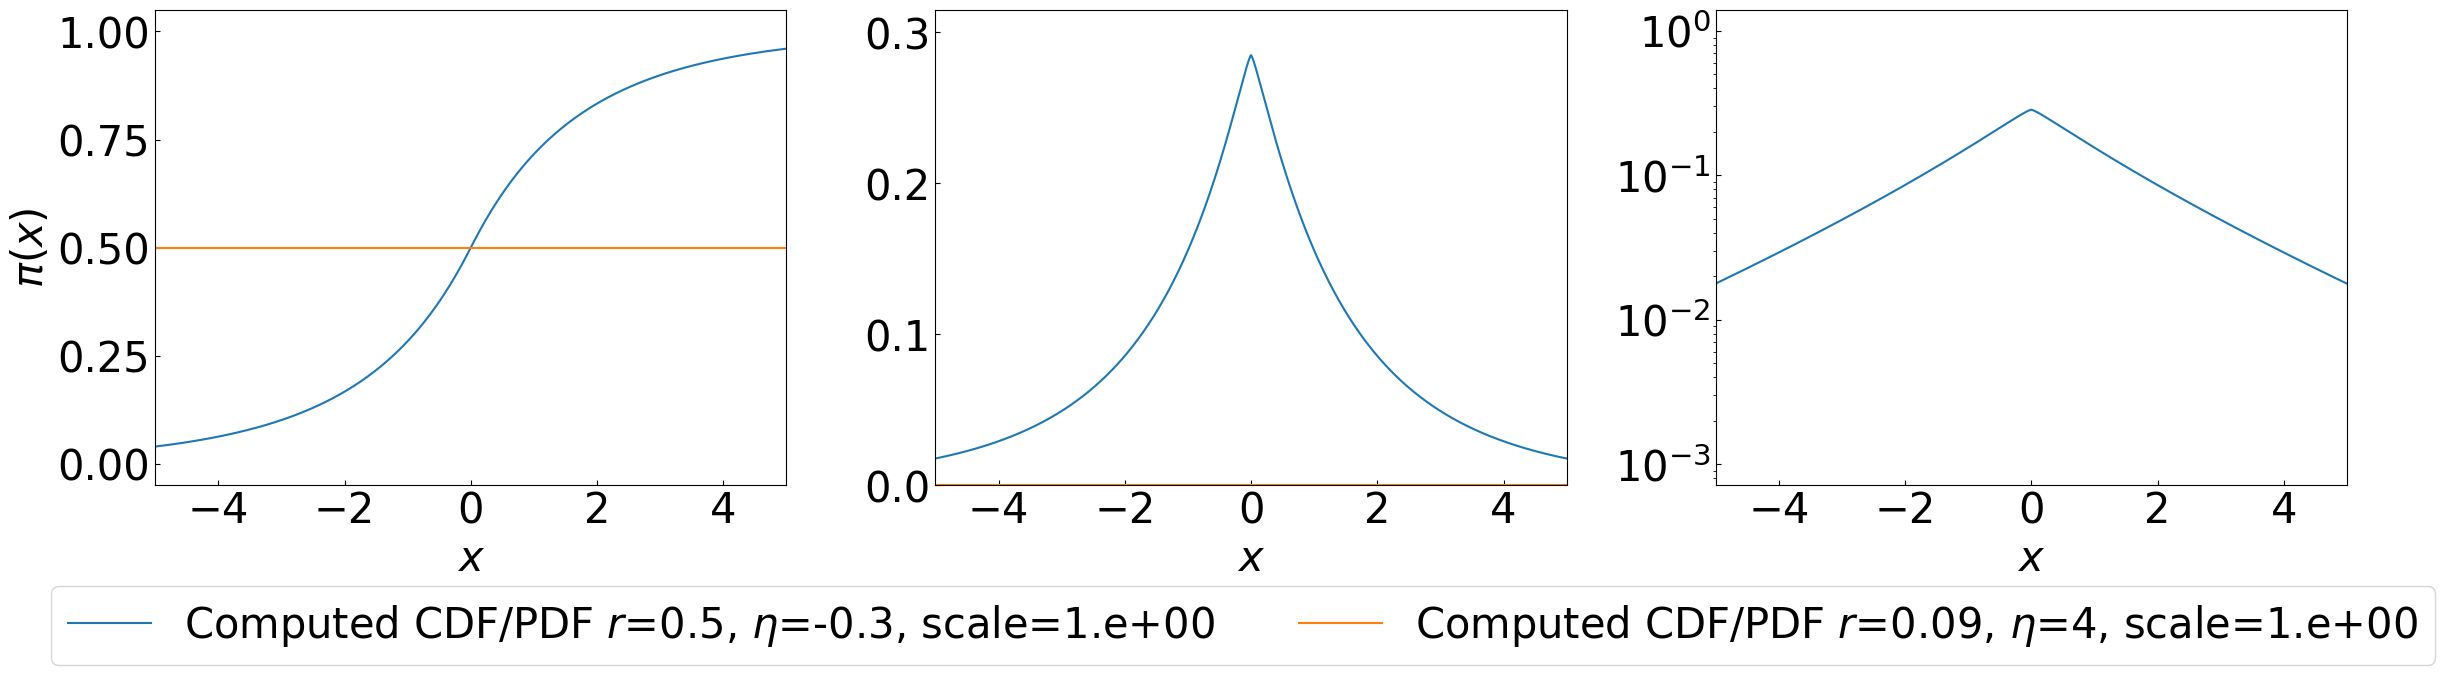

[-5, 5]


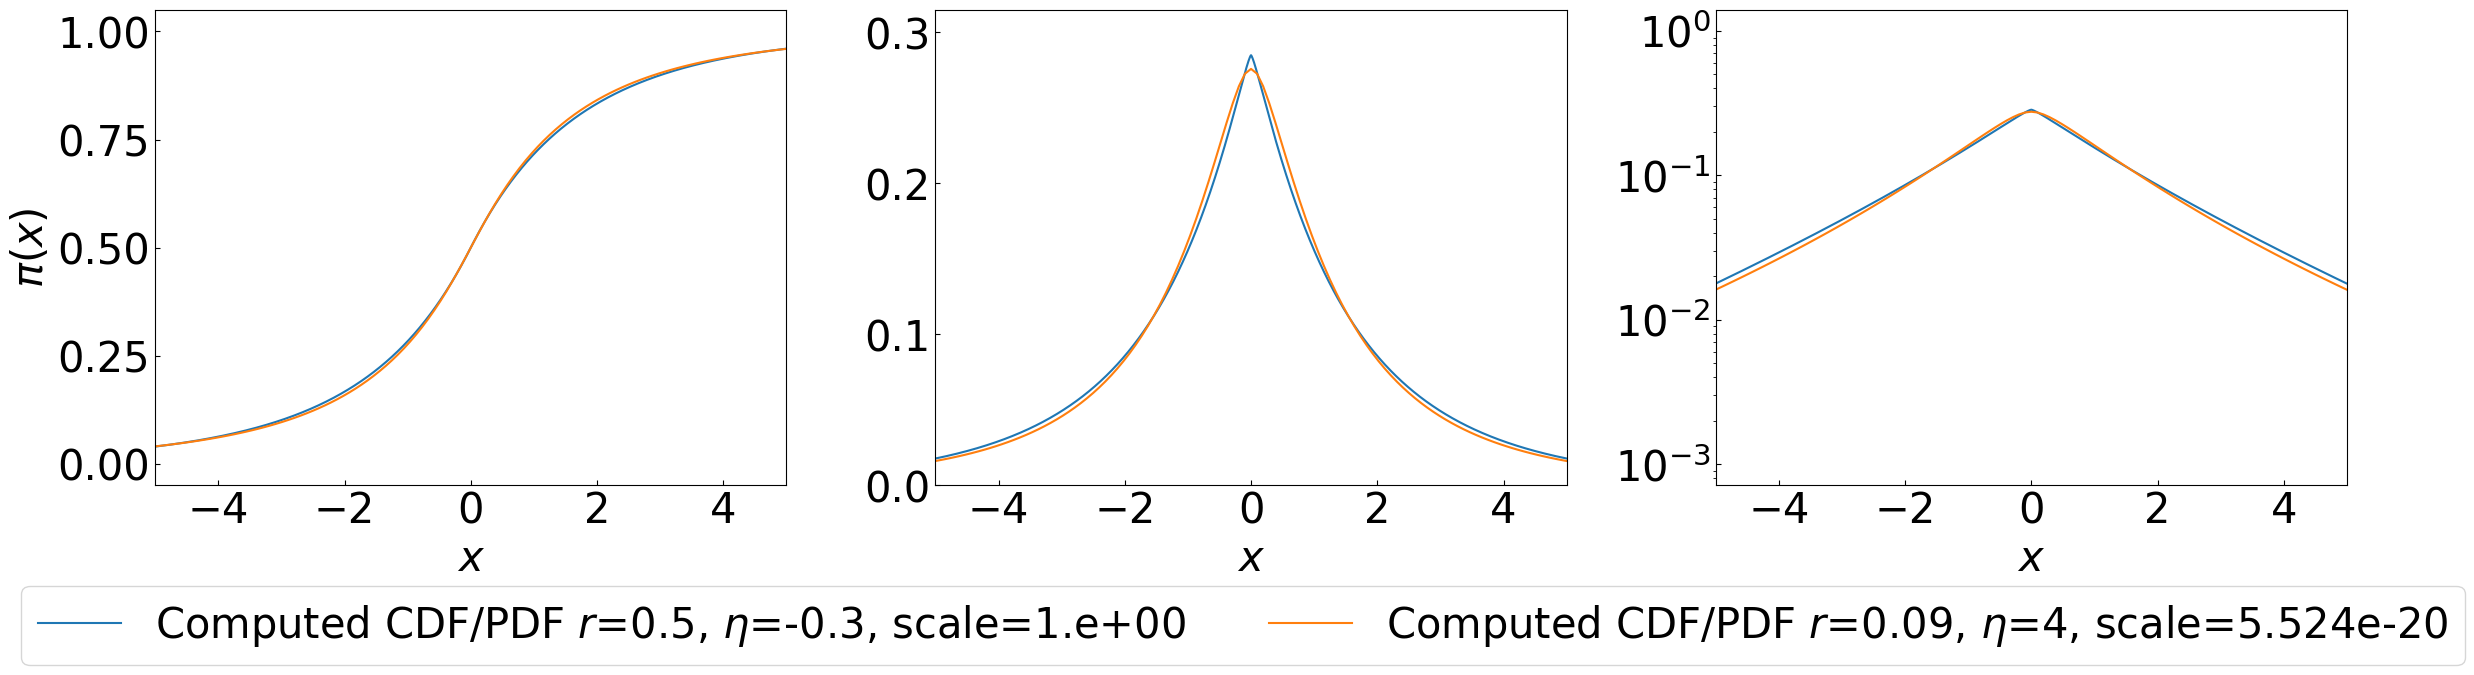

In [13]:
r1, eta1, scale1 = 0.5, -0.3, 1
r2, eta2, scale2 = 0.09, 4, 1
n_samples = 2000

visualize_cdf_pdf(
    (r1, eta1, scale1),
    (r2, eta2, scale2),
    distro=distro,
    log_scale=log_scale,
    n_samples=n_samples,
    interval=[-5,5],
    provided_loc=provided_loc,
    group=group,
    percent_excluded=percent_excluded,
    plot_hist=plot_hist,
    bw=bw,
    bw_log=bw_log,
    binwidth=binwidth
);


r1, eta1, scale1 = 0.5, -0.3, 1
r2, eta2, scale2 = 0.09, 4, 5.580e-20/9.183e-1/1.1
n_samples = 2000
visualize_cdf_pdf(
    (r1, eta1, scale1),
    (r2, eta2, scale2),
    distro=distro,
    log_scale=log_scale,
    n_samples=n_samples,
    interval=[-5,5],
    provided_loc=provided_loc,
    group=group,
    percent_excluded=percent_excluded,
    plot_hist=plot_hist,
    bw=bw,
    bw_log=bw_log,
    binwidth=binwidth
);



[-25, 25]


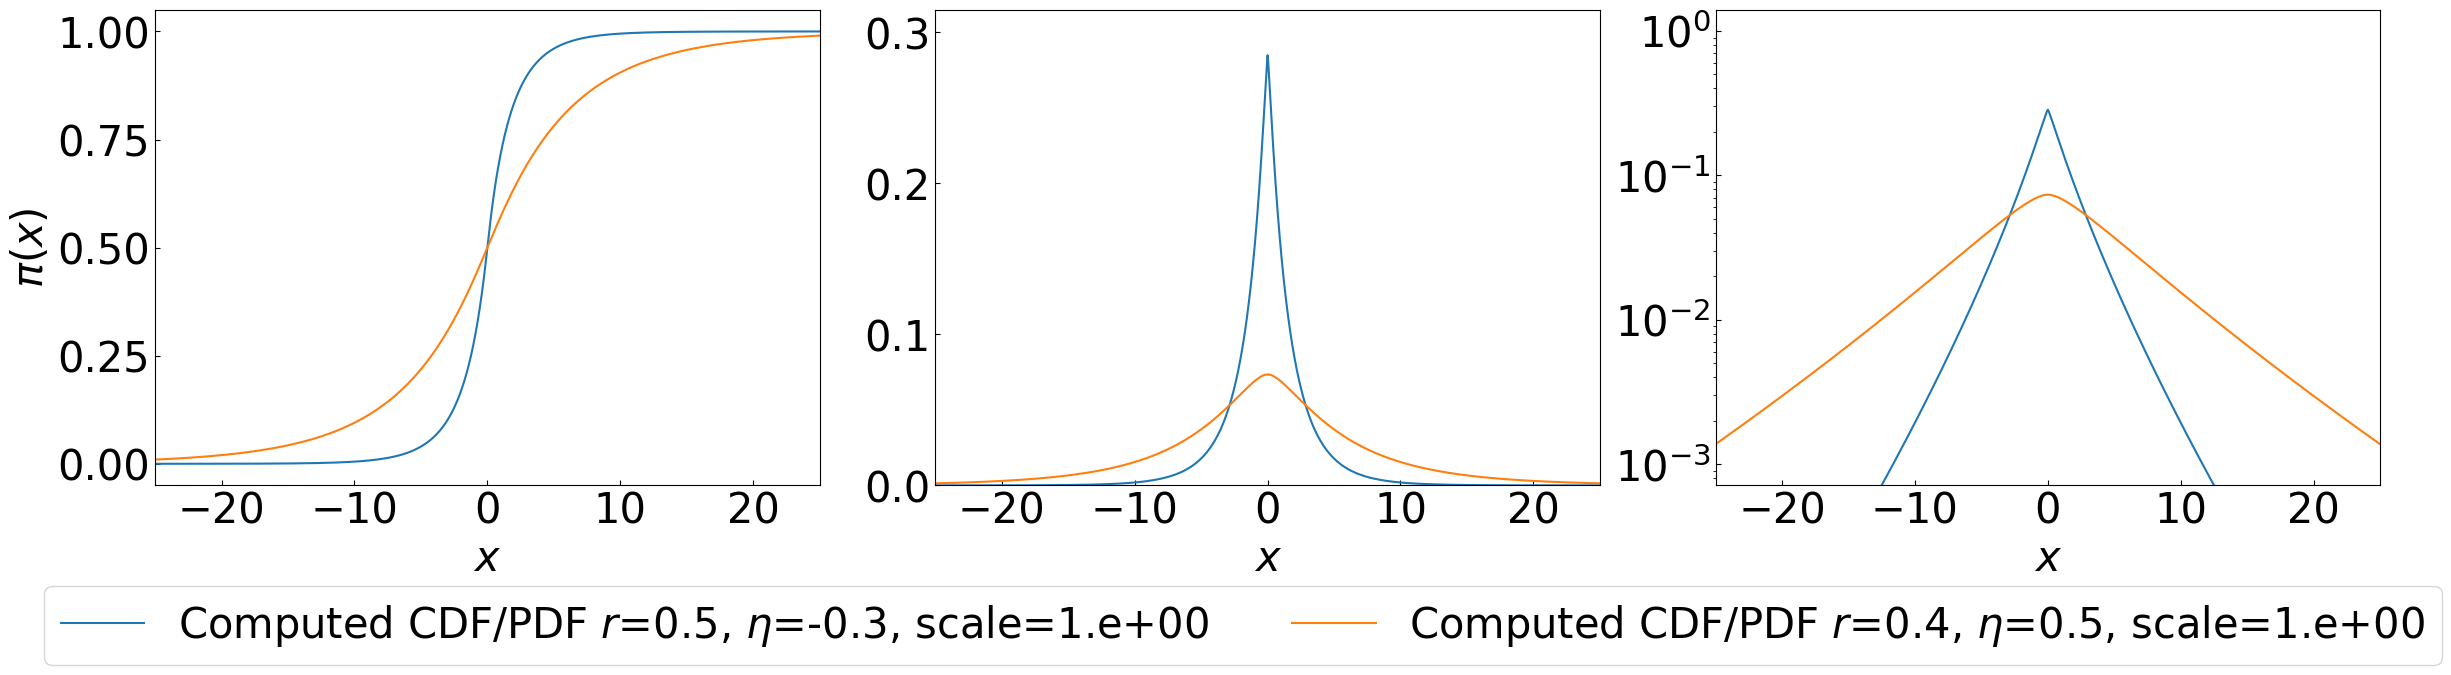

[-25, 25]


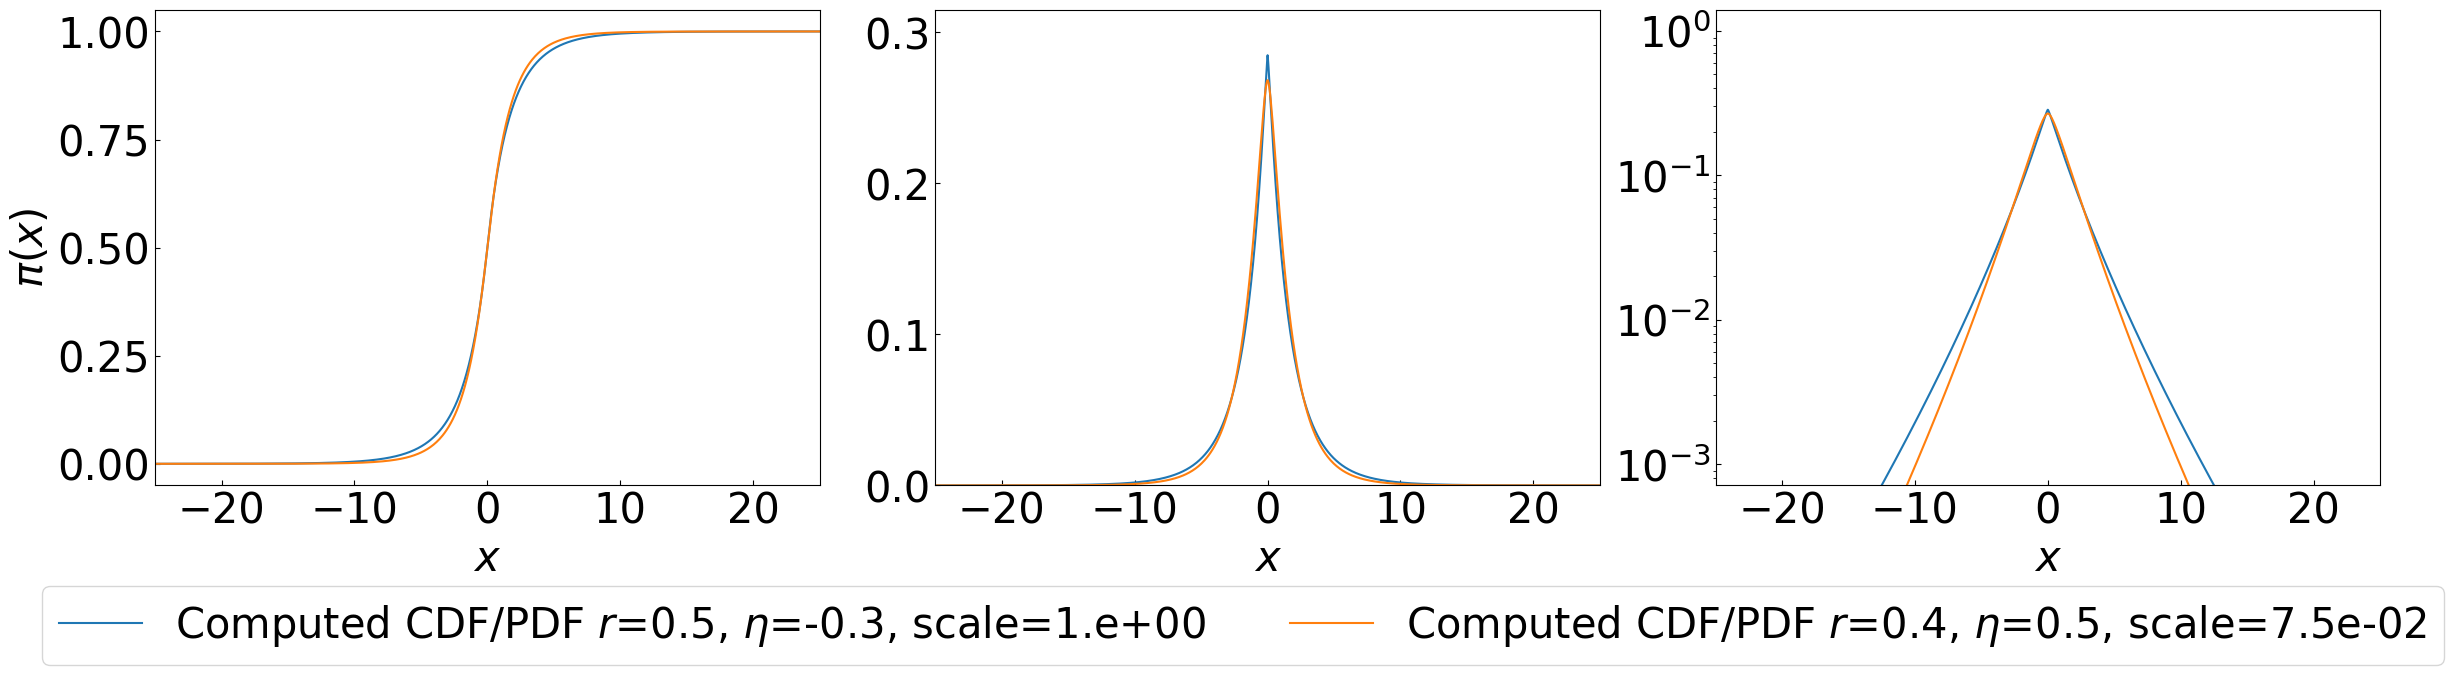

In [14]:
r1, eta1, scale1 = 0.5, -0.3, 1
r2, eta2, scale2 = 0.4, 0.5, 1
n_samples = 2000

fig1 = visualize_cdf_pdf(
    (r1, eta1, scale1),
    (r2, eta2, scale2),
    distro=distro,
    log_scale=log_scale,
    n_samples=n_samples,
    interval=[-25,25],
    provided_loc=provided_loc,
    group=group,
    percent_excluded=percent_excluded,
    plot_hist=plot_hist,
    bw=bw,
    bw_log=bw_log,
    binwidth=binwidth
);
if (SAVE_FIGS):
    fig1.savefig(os.path.join(plots_path, 'scale_change_top.jpg'), bbox_inches='tight')

r1, eta1, scale1 = 0.5, -0.3, 1
r2, eta2, scale2 = 0.4, 0.5, 0.075
fig2 = visualize_cdf_pdf(
    (r1, eta1, scale1),
    (r2, eta2, scale2),
    distro=distro,
    log_scale=log_scale,
    n_samples=n_samples,
    interval=[-25,25],
    provided_loc=provided_loc,
    group=group,
    percent_excluded=percent_excluded,
    plot_hist=plot_hist,
    bw=bw,
    bw_log=bw_log,
    binwidth=binwidth
);

if (SAVE_FIGS):
    fig2.savefig(os.path.join(plots_path, 'scale_change_bottom.jpg'), bbox_inches='tight')
